# Notebook to develop the model for the project

In [18]:
# All our imports
import torch 
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from random import randint
#for all the plots to be inline
%matplotlib inline 


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [19]:
'''Data Set manipulation'''


'Data Set manipulation'

In [20]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # more analysis required to determine the specifics of the architecture
       
        self.n_output = 8
        self.n_channel = 1
    
        self.cnn_layers = nn.Sequential(
        #         imageInputLayer([28 28 1])
        #         convolution2dLayer(3,8,'Padding','same')
                nn.Conv2d(1, 8, 3), 
        #         batchNormalizationLayer
                nn.BatchNorm2d(8),
        #         reluLayer
                nn.LeakyReLU(),
        #         averagePooling2dLayer(2,'Stride',2)
                nn.MaxPool2d(2, 2),
        #         convolution2dLayer(3,16,'Padding','same')
                nn.Conv2d(8, 16, 3),
        #         batchNormalizationLayer
                nn.BatchNorm2d(16),
        #         reluLayer
                nn.LeakyReLU(),
        #         averagePooling2dLayer(2,'Stride',2)
                nn.MaxPool2d(2, 2),
        #         convolution2dLayer(3,32,'Padding','same')
                nn.Conv2d(16, 32, 3),
        #         batchNormalizationLayer
                nn.BatchNorm2d(32),
        #         reluLayer
                nn.LeakyReLU(),
        #         convolution2dLayer(3,32,'Padding','same')
                nn.Conv2d(32, 32, 3),
        #         batchNormalizationLayer
                nn.BatchNorm2d(32),
        #         reluLayer
                nn.LeakyReLU(),
        #         Max pooling layer
                nn.MaxPool2d(2, 2)
        )

        self.n_input = 2592# 96*96 
        #TODO:actual value might be determined from the computed output of the cnn layers
        # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

        self.fc_layers = nn.Sequential(
#         fullyConnectedLayer(1)
                nn.Linear(self.n_input,  128),
                nn.LeakyReLU(),
                nn.Linear(128, 256),
                nn.LeakyReLU(),
                nn.Linear(256, 64),
                nn.LeakyReLU(),
                nn.Linear(64, self.n_output),
                nn.LeakyReLU()
        )


#         regressionLayer
        self.criterion = nn.MSELoss()       
#         dropoutLayer(0.2)
        self.dropout =  nn.Dropout(p=0.2)
        

        
    def forward(self, x):
        #feedword pass through our network
        x = self.cnn_layers(x)
        x = x.view(x.shape[0], -1) #flatten the input tensor
        x = self.fc_layers(x)
        
        return x


    @staticmethod
    def load_checkpoint(new_model, filepath):
        checkpoint = torch.load(filepath)
        model = new_model.Network(checkpoint['input_size'], 
            checkpoint['output_size'],
            checkpoint['hidden_layers']
            )

        model.load_state_dict(checkpoint['state_dict'])

        return model
    
    def save(self):
        self.checkpoint = {
            'input_size': self.n_input, 
            'output_size': self.n_output,
            'hidden_layers': [each.out_features for each in model.hidden_layers],
            'state_dict': model.state_dict()
        }
        torch.save(self.checkpoint, 'checkpoint.pth')
    


In [21]:
    
def validation(model, testloader, criterion):
    accuracy = 0
    test_loss = 0
    for images, labels in testloader:

        images = images.resize_(images.size()[0], 784)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ## Calculating the accuracy 
        # Model's output is log-softmax, take exponential to get the probabilities
        ps = torch.exp(output)
        # Class with highest probability is our predicted class, compare with true label
        equality = (labels.data == ps.max(1)[1])
        # Accuracy is number of correct predictions divided by all predictions, just take the mean
        accuracy += equality.type_as(torch.FloatTensor()).mean()

    return test_loss, accuracy


def train(model, trainloader, testloader, criterion, optimizer, epochs=5, print_every=40):
    
    steps = 0
    running_loss = 0
    for e in range(epochs):
        # Model in training mode, dropout is on
        model.train()
        for images, labels in trainloader:
            steps += 1
            
            # Flatten images into a 784 long vector
            images.resize_(images.size()[0], 784)
            
            optimizer.zero_grad()
            
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            if steps % print_every == 0:
                # Model in inference mode, dropout is off
                model.eval()
                
                # Turn off gradients for validation, will speed up inference
                with torch.no_grad():
                    test_loss, accuracy = validation(model, testloader, criterion)
                
                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                      "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
                
                running_loss = 0
                
                # Make sure dropout and grads are on for training
                model.train()

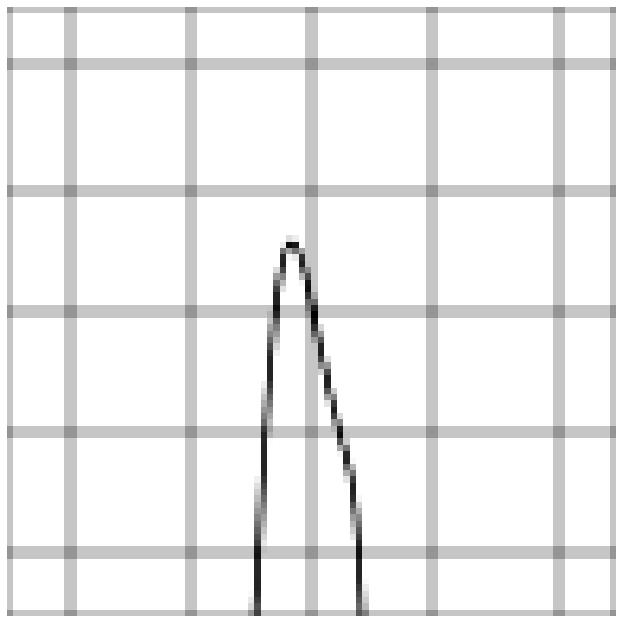

In [22]:


# get imaages
data_dir = 'C:\\Users\\the_3\\Desktop\\poly-curve-detector\\DataGeneration\\plotData'

transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor()])

sampledataset = datasets.ImageFolder(data_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(sampledataset, batch_size=128)

images, labels = next(iter(dataloader))
figure = plt.figure(figsize=(24,24))
plots = 2
for i in range(1, plots + 1):
    sample_idx = torch.randint(len(sampledataset), size=(1,)).item()
    img, label = sampledataset[sample_idx]
    figure.add_subplot(1, plots, i)
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0), cmap="gray")
    break
    
plt.show()

In [23]:
model = Network()
optimizer = optim.Adam(model.parameters(), lr=0.005)

output = model.forward(images)
print(output)

tensor([[ 0.0613,  0.0051,  0.1136,  ..., -0.0014, -0.0004, -0.0012],
        [ 0.0772,  0.0122,  0.1271,  ..., -0.0019, -0.0004, -0.0010],
        [ 0.0917,  0.0367,  0.0940,  ..., -0.0015, -0.0004, -0.0007],
        ...,
        [ 0.0798,  0.0288,  0.1248,  ..., -0.0016, -0.0006, -0.0007],
        [ 0.0817,  0.0440,  0.0944,  ..., -0.0017, -0.0003, -0.0006],
        [ 0.0877,  0.0139,  0.1109,  ..., -0.0018, -0.0003, -0.0008]],
       grad_fn=<LeakyReluBackward0>)


In [25]:
output.shape
output[0,]

tensor([ 6.1272e-02,  5.0621e-03,  1.1357e-01, -8.7433e-05, -2.9058e-05,
        -1.3742e-03, -3.7763e-04, -1.2024e-03], grad_fn=<SelectBackward>)